In [1]:
import sys
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import joblib
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from gensim import corpora
from gensim.models import LdaModel

In [2]:
src_path = str((Path.cwd().parent / 'src').resolve())
if src_path not in sys.path:
    sys.path.append(src_path)

from src.utils import get_features
from src.plot import plot_logreg_evaluation

In [3]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [4]:
DATA_DIR = "../data/processed/"
MODEL_DIR = "../models/log_reg/"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

train = pd.read_csv(DATA_DIR + "train.csv")
val   = pd.read_csv(DATA_DIR + "val.csv")
test  = pd.read_csv(DATA_DIR + "test.csv")

# Drop any rows with missing values just in case
train.dropna(inplace=True), val.dropna(inplace=True), test.dropna(inplace=True)

# Separate labels
y_train, y_val, y_test = train.pop("is_fake"), val.pop("is_fake"), test.pop("is_fake")

print(f"Train shape (with features): {train.shape}")
print(f"Val   shape (with features): {val.shape}")
print(f"Test  shape (with features): {test.shape}")

Train shape (with features): (44145, 3)
Val   shape (with features): (9461, 3)
Test  shape (with features): (9466, 3)


In [5]:
features_columns = [
    "word_count", "char_count", "avg_word_length",
    "polarity", "subjectivity", "reading_ease", "smog_index"
]

scaler = StandardScaler()
# get_features() returns a DataFrame with features_columns added to the split
X_train_feats = scaler.fit_transform(get_features(train)[features_columns])
X_val_feats = scaler.transform(get_features(val)[features_columns])
X_test_feats = scaler.transform(get_features(test)[features_columns])

print(f"Scaled numeric features shape: train {X_train_feats.shape}, val {X_val_feats.shape}, test {X_test_feats.shape}")
joblib.dump(scaler, MODEL_DIR + "scaler.joblib")

Scaled numeric features shape: train (44145, 7), val (9461, 7), test (9466, 7)


['../models/log_reg/scaler.joblib']

In [6]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    sublinear_tf=True,
    max_features=5000
)

X_train_tfidf = tfidf.fit_transform(train["processed_text"])
X_val_tfidf = tfidf.transform(val["processed_text"])
X_test_tfidf = tfidf.transform(test["processed_text"])

joblib.dump(tfidf, MODEL_DIR + "tfidf_vectorizer.joblib")

print(f"Saved TF–IDF Vectorizer to '{MODEL_DIR}tfidf_vectorizer.joblib")
print(f"TF–IDF shapes: train {X_train_tfidf.shape}, val {X_val_tfidf.shape}, test {X_test_tfidf.shape}")

Saved TF–IDF Vectorizer to '../models/log_reg/tfidf_vectorizer.joblib
TF–IDF shapes: train (44145, 5000), val (9461, 5000), test (9466, 5000)


In [7]:
# Build Gensim Dictionary & Corpus on training split
processed_texts = [txt.split() for txt in train["processed_text"]]
id2word = corpora.Dictionary(processed_texts)
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)
id2word.save(MODEL_DIR + "lda_dictionary.dict")
print(f"LDA dictionary saved: {len(id2word)} tokens")

bow_train = [id2word.doc2bow(text) for text in processed_texts]
bow_val = [id2word.doc2bow(txt.split()) for txt in val["processed_text"]]
bow_test = [id2word.doc2bow(txt.split()) for txt in test["processed_text"]]

LDA dictionary saved: 10000 tokens


In [8]:
# Train LDA model
best_k = 24  # chosen from coherence tuning
lda = LdaModel(
    corpus=bow_train,
    id2word=id2word,
    num_topics=best_k,
    passes=15,
    random_state=SEED,
    chunksize=2000,
    alpha="auto",
    per_word_topics=False
)
lda.save(MODEL_DIR + "lda_model.model")
print(f"Trained LDA model with {best_k} topics")

Trained LDA model with 24 topics


In [9]:
def get_topic_dist(model, bow_corpus, num_topics):
    """
    For each document in bow_corpus, returns a vector of length num_topics
    containing the probability of each topic for that document.
    """
    arr = np.zeros((len(bow_corpus), num_topics), dtype=np.float32)
    for i, bow in enumerate(bow_corpus):
        for topic_id, prob in model.get_document_topics(bow, minimum_probability=0.0):
            arr[i, topic_id] = prob
    return arr

X_train_lda = get_topic_dist(lda, bow_train, best_k)
X_val_lda = get_topic_dist(lda, bow_val, best_k)
X_test_lda = get_topic_dist(lda, bow_test, best_k)

print(f"LDA topic distributions shape: train {X_train_lda.shape}, val {X_val_lda.shape}, test {X_test_lda.shape}")

LDA topic distributions shape: train (44145, 24), val (9461, 24), test (9466, 24)


In [10]:
# Concatenating TF–IDF, LDA, and numeric features into final matrices
X_train = sparse.hstack([
    X_train_tfidf,
    sparse.csr_matrix(X_train_lda),
    sparse.csr_matrix(X_train_feats)
])
X_val = sparse.hstack([
    X_val_tfidf,
    sparse.csr_matrix(X_val_lda),
    sparse.csr_matrix(X_val_feats)
])
X_test = sparse.hstack([
    X_test_tfidf,
    sparse.csr_matrix(X_test_lda),
    sparse.csr_matrix(X_test_feats)
])

In [11]:
# Stack train + val for tuning
X_tune = sparse.vstack([X_train, X_val])
y_tune = np.concatenate([y_train, y_val])

# PredefinedSplit: train indices = -1, val indices = 0
test_fold = np.array([-1] * X_train.shape[0] + [0] * X_val.shape[0])
ps = PredefinedSplit(test_fold)

base_lr = LogisticRegression(
    solver="saga",
    class_weight="balanced",
    max_iter=5000,
    random_state=SEED,
    n_jobs=-1
)

param_grid = {"C": [0.01, 0.1, 1.0, 10.0]}
grid = GridSearchCV(
    estimator=base_lr,
    param_grid=param_grid,
    cv=ps,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_tune, y_tune)
print(f"Best hyperparameter C: {grid.best_params_['C']}")
print(f"Best validation ROC-AUC: {grid.best_score_:.4f}")

Fitting 1 folds for each of 4 candidates, totalling 4 fits
Best hyperparameter C: 10.0
Best validation ROC-AUC: 0.9935


In [12]:
# retrain on full train+val
best_C = grid.best_params_["C"]
final_lr = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=best_C,
    class_weight="balanced",
    max_iter=5000,
    random_state=SEED,
    n_jobs=-1
)
final_lr.fit(X_tune, y_tune)
joblib.dump(final_lr, MODEL_DIR + "logreg_model.joblib")
print("Saved final Logistic Regression model to 'logreg_model.joblib'")

Saved final Logistic Regression model to 'logreg_model.joblib'



--- Test Results ---
              precision    recall  f1-score   support

        real       0.97      0.96      0.97      5219
        fake       0.95      0.96      0.96      4247

    accuracy                           0.96      9466
   macro avg       0.96      0.96      0.96      9466
weighted avg       0.96      0.96      0.96      9466

ROC-AUC: 0.9932


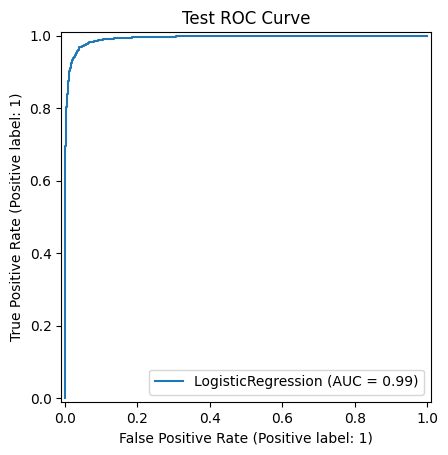

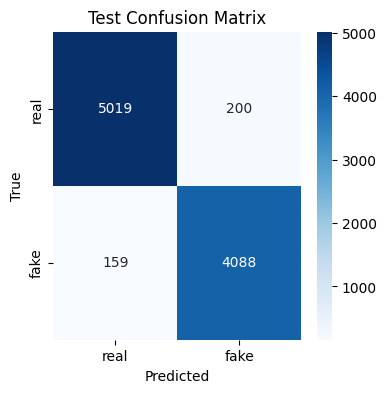

In [13]:
plot_logreg_evaluation("Test", final_lr, X_test, y_test)